# The Transient Universe part 2

In [1]:
import numpy as np
from numpy import random as rnd
import emcee
import matplotlib.pyplot as plt
import scipy

import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

7) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.


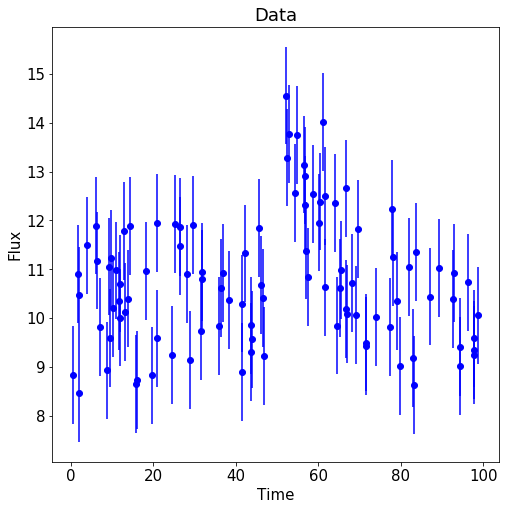

In [2]:
data = np.load("transient.npy")
#print(data)

t = data[:,0] #time
f = data[:,1] #flux
f_err = data[:,2] #flux error

plt.errorbar(t, f, yerr=f_err, fmt='o', color='b')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Data')
plt.show()

Model to use here:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

In [3]:
#burst model
def model(p, t):
    b, A, t_0, alpha = p
    return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))

We change the parameters space for nested sampling priors.  For the priors I make them 
$b=[0,50]$, $A=[0,50]$, $t_0=[0,100]$, and $\alpha=[-5,5]$.

## Nested Sampling

In [4]:
#define the dimensionality of the problem
ndim = 4

#x are the samples
def priormodel(x): 
    b = x[0]*50
    A = x[1]*50
    t_0 = x[2]*100
    alpha = scipy.stats.loguniform.ppf(x[3], np.exp(-5), np.exp(5))
    
    param = np.array([b, A, t_0, alpha])
    return param


def loglike_model(param, t, f, f_err):
    b, A, t_0, alpha = param 
    model_brust = model(param, t)
    return (-0.5)* np.sum((f - model_brust)**2/(f_err**2))
    

In [5]:
#nested sampling

sampler = dynesty.NestedSampler(loglike_model, priormodel, ndim, logl_args=[t, f, f_err], nlive=1000)
sampler.run_nested()
sresults = sampler.results

/home/federica/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/federica/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
3483it [00:15, 72.82it/s, bound: 0 | nc: 9 | ncall: 34563 | eff(%): 10.077 | loglstar:   -inf < -187.530 <    inf | logz: -196.106 +/-  0.087 | dlogz: 126.344 >  1.009]     /home/federica/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/home/federica/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.
3664it [00:17, 144.09it/s, bound: 1 | nc: 10 | ncall: 36286 | eff(%): 10.098 | loglstar:   -inf < -160.211 <    inf | logz: -168.676 +/-  0.085 | dlogz: 98.684 >  1.009] /ho

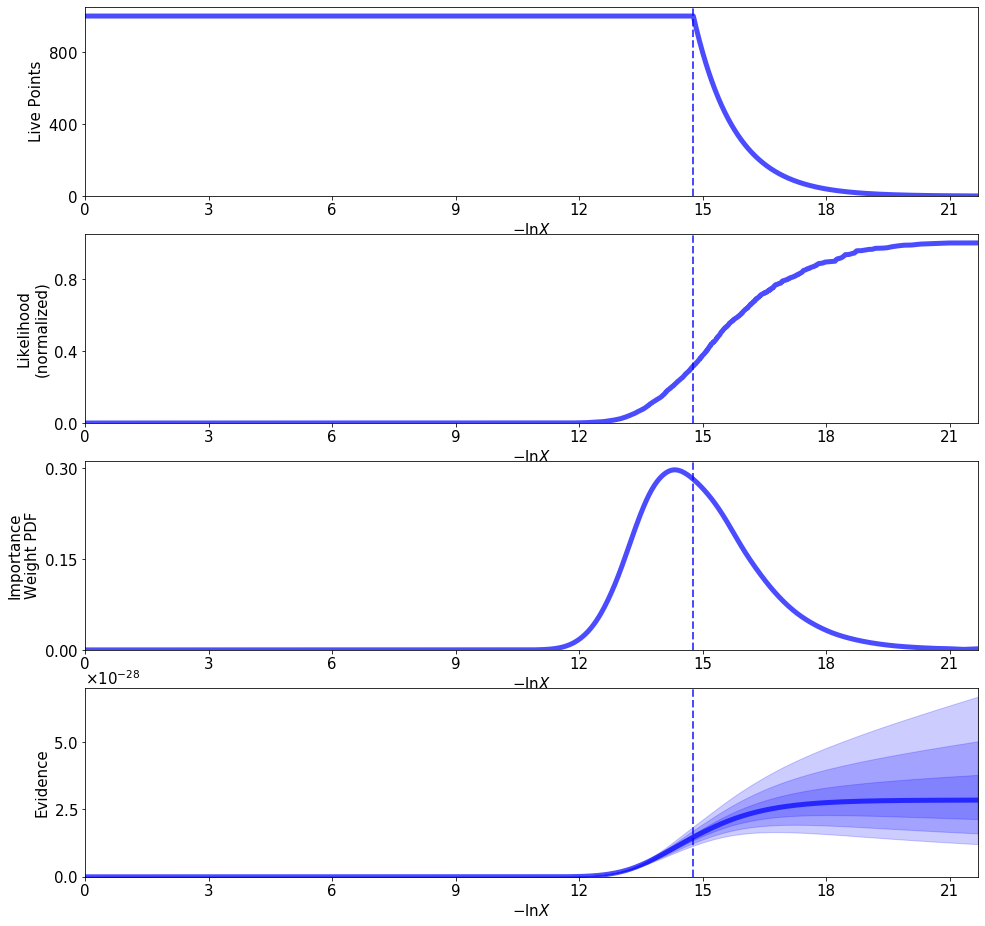

In [6]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

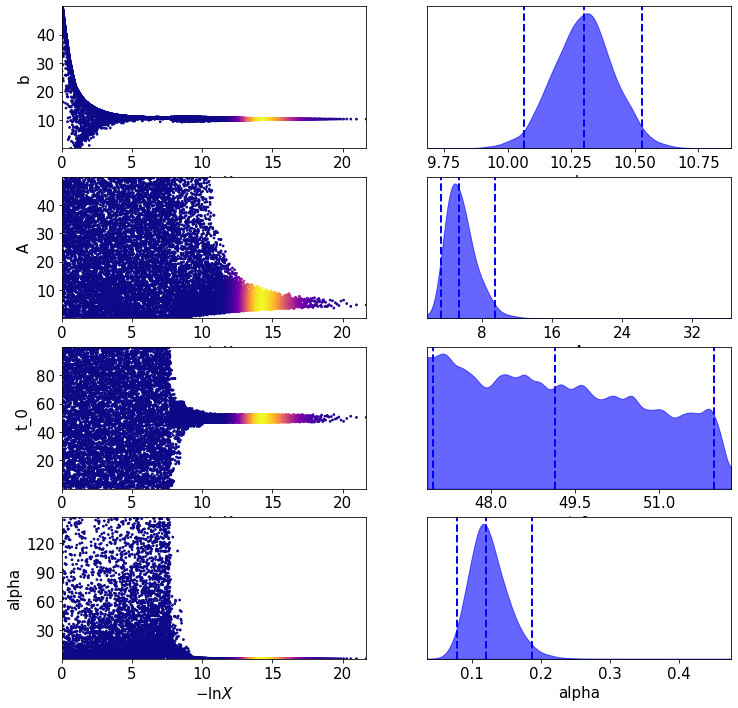

In [7]:
label_brust = ['b', 'A', 't_0', 'alpha']

tfig, taxes = dyplot.traceplot(sresults, labels=label_brust)

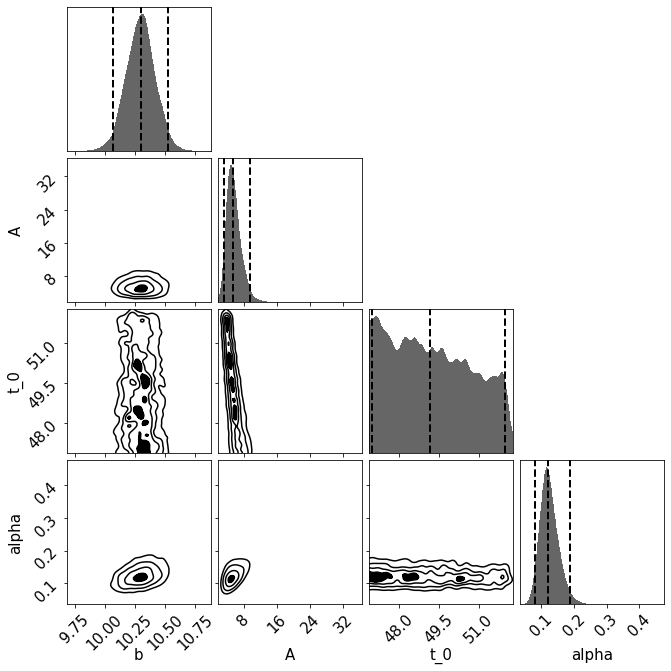

In [8]:
#We make a corner plot
cfig, caxes = dyplot.cornerplot(sresults, labels=label_brust)

In [9]:
#We want to see if the results we obtained are equivalent to the ones we found with MCMC

#extract the samples and find the weights
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

Bayesian evidence 2.848359869067415e-28
68% parameter credible regions are:
 [[10.180732074663188, 10.415379025927818], [4.146831865518046, 7.233369751082803], [47.506175939342775, 51.05704494291499], [0.09896874415903528, 0.1514301051940595]]



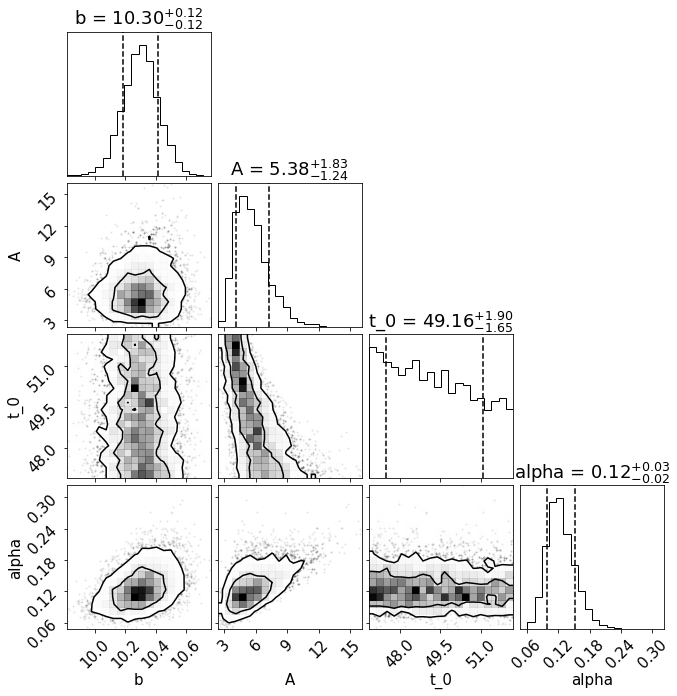

In [10]:
# Resample weighted samples
samples_equal = dyfunc.resample_equal(samples, weights)

#make a new cornerplot
corner.corner(samples_equal, labels=label_brust, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True);

We can see that the results we obtained are pretty equivalent to what we obtained for the MCMC.

In [11]:
median = np.empty(ndim)
quantile_95 = np.empty(ndim) 
quantile_05 = np.empty(ndim) 

for i in range(ndim):
    median[i] = np.median(samples_equal[:, i])
    quantile_95[i] = np.quantile(samples_equal[:, i], 0.95)
    quantile_05[i] = np.quantile(samples_equal[:, i], 0.05)
    
    up = quantile_95[i] - median[i]
    low = median[i] - quantile_05[i]
    
    print(label_brust[i],'=', str(round(median[i], 2)),'+', str(round(up, 2)), '-', str(round(low, 2)))

b = 10.3 + 0.19 - 0.2
A = 5.38 + 3.35 - 1.81
t_0 = 49.16 + 2.68 - 2.1
alpha = 0.12 + 0.05 - 0.04


## Gaussian Profile

8) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

In [12]:
def gauss_model(p, t):
    b, A, t_0, sigma = p
    return b + A * np.exp(-(t-t_0)**2/(2*sigma**2))

We started by fitting manually the model to the data.

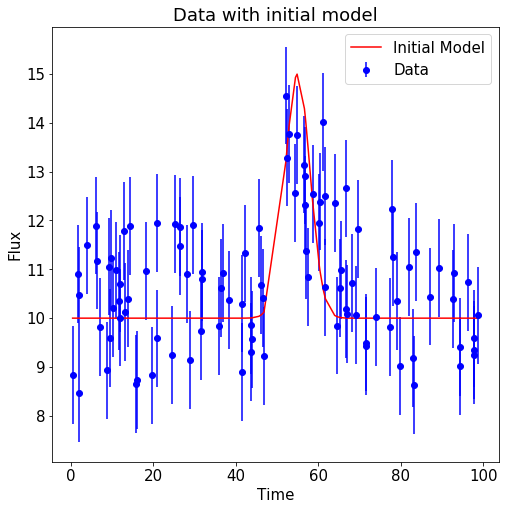

In [13]:
b = 10
A = 5
t_0 = 55 
sigma = 3

p = [b, A, t_0, sigma]

gauss_fit = gauss_model(p, t)

plt.plot(t, gauss_fit, label='Initial Model', color='r')
plt.errorbar(t, f, yerr=f_err, fmt='o', color='b', label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.title('Data with initial model')
plt.show()

In [14]:
#define the dimensionality of the problem
ndim = 4

#x are the samples
def priormodel(x): 
    b = x[0]*50
    A = x[1]*50
    t_0 = x[2]*100
    sigma = scipy.stats.loguniform.ppf(x[3], np.exp(-2), np.exp(2))
    
    param = np.array([b, A, t_0, sigma])
    return param


def loglike_model(param, t, f, f_err):
    b, A, t_0, sigma = param 
    model_brust_gauss = gauss_model(param, t)
    return (-0.5)* np.sum((f - model_brust_gauss)**2/(f_err**2))

In [15]:
#nested sampling

sampler_gauss = dynesty.NestedSampler(loglike_model, priormodel, ndim, logl_args=[t, f, f_err], nlive=1000)
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results

8198it [02:23, 28.13it/s, bound: 62 | nc: 81 | ncall: 128362 | eff(%):  6.387 | loglstar:   -inf < -86.030 <    inf | logz: -94.258 +/-  0.082 | dlogz: 31.890 >  1.009]      /home/federica/anaconda/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  'The enlargement factor for the ellipsoidal bounds'
9360it [03:01,  5.03it/s, bound: 83 | nc: 173 | ncall: 159497 | eff(%):  5.868 | loglstar:   -inf < -77.183 <    inf | logz: -88.387 +/-  0.100 | dlogz: 25.098 >  1.009]/home/federica/anaconda/lib/python3.7/site-packages/dynesty/bounding.py:619: UserWarning: The enlargement factor for the ellipsoidal bounds deter

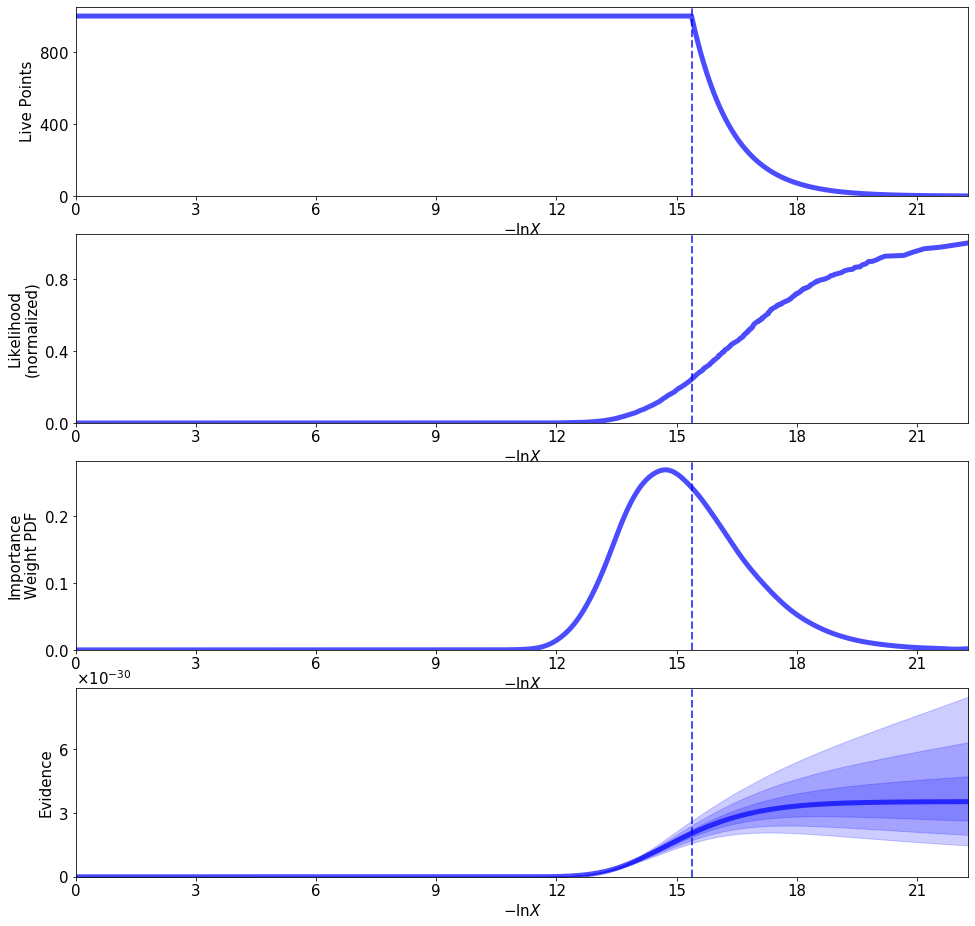

In [16]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_gauss)

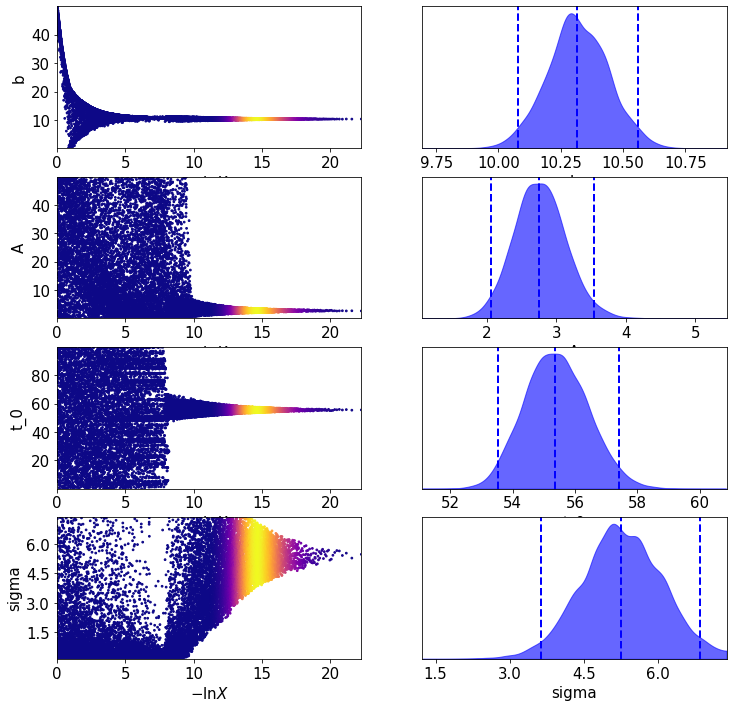

In [17]:
label_brust_gauss = ['b', 'A', 't_0', 'sigma']

tfig, taxes = dyplot.traceplot(sresults_gauss, labels=label_brust_gauss)

In [18]:
#We want to see if the results we obtained are equivalent to the ones we found with MCMC

#extract the samples and find the weights
samples_gauss = sresults_gauss.samples  # samples
weights_gauss = np.exp(sresults_gauss.logwt - sresults_gauss.logz[-1])  # normalized weights
evidence_gauss = sresults_gauss.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gauss))

# Compute 10%-90% quantiles
quantiles_gauss = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gauss) for samps in samples_gauss.T]
print('68% parameter credible regions are:\n ' + str(quantiles_gauss) + '\n')

Bayesian evidence 3.525131136135132e-30
68% parameter credible regions are:
 [[10.19998651928802, 10.436647250313733], [2.398605933939711, 3.1273692447160184], [54.39406079154735, 56.40399875994844], [4.444766872490033, 6.080965182453936]]



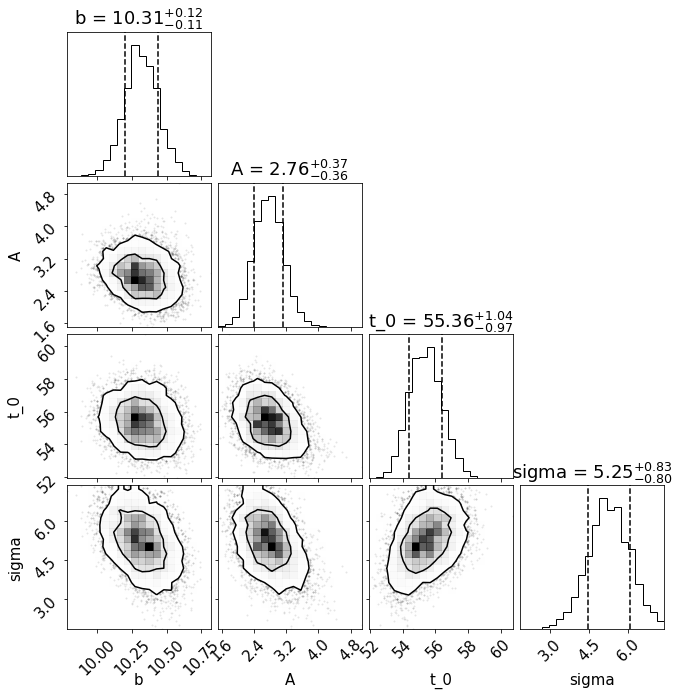

In [19]:
# Resample weighted samples
samples_equal_gauss = dyfunc.resample_equal(samples_gauss, weights_gauss)

#make a new cornerplot
corner.corner(samples_equal_gauss, labels=label_brust_gauss, 
              levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True);

In [20]:
median_gauss = np.empty(ndim)
quantile_95 = np.empty(ndim) 
quantile_05 = np.empty(ndim) 

for i in range(ndim):
    median_gauss[i] = np.median(samples_equal_gauss[:, i])
    quantile_95[i] = np.quantile(samples_equal_gauss[:, i], 0.95)
    quantile_05[i] = np.quantile(samples_equal_gauss[:, i], 0.05)
    
    up = quantile_95[i] - median[i]
    low = median[i] - quantile_05[i]
    
    print(label_brust_gauss[i],'=', str(round(median_gauss[i], 2)),'+', 
          str(round(up, 2)), '-', str(round(low, 2)))

b = 10.31 + 0.22 - 0.19
A = 2.76 + -1.99 - 3.21
t_0 = 55.36 + 7.95 - -4.63
sigma = 5.25 + 6.46 - -3.79


## Model Comparison

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

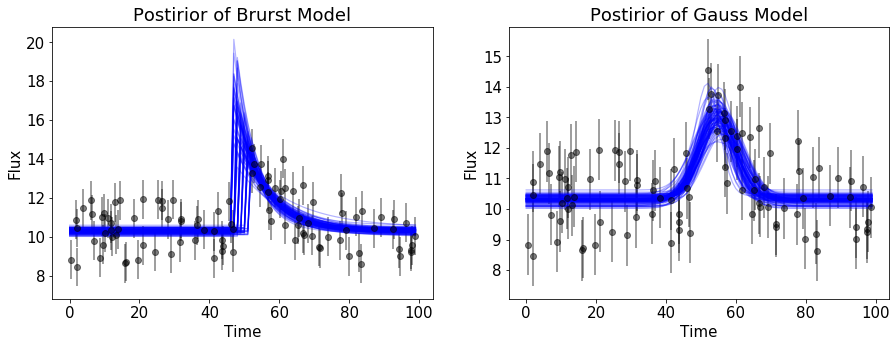

In [21]:
data_burst = samples_equal[np.random.choice(range(len(samples_equal)), 100)]
data_gauss = samples_equal_gauss[np.random.choice(range(len(samples_equal_gauss)), 100)]
time = np.linspace(0, 100, 100)

flux_burst = np.array([model(p, time) for p in data_burst])
flux_gauss = np.array([gauss_model(p, time) for p in data_gauss])

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)

for i in range(len(flux_burst)):
    plt.plot(flux_burst[i], alpha=0.3, color='b', lw=1.2)
    plt.title('Postirior of Brurst Model')
    plt.xlabel('Time')
    plt.ylabel('Flux')

plt.errorbar(t, f, yerr=f_err, fmt='o', color='black', alpha=0.5, label='Data')

ax = fig.add_subplot(122)

for i in range(len(flux_gauss)):
    plt.plot(flux_gauss[i], alpha=0.3, color='b', lw=1.2)
    plt.title('Postirior of Gauss Model')
    plt.xlabel('Time')
    plt.ylabel('Flux')

plt.errorbar(t, f, yerr=f_err, fmt='o', color='black', alpha=0.5, label='Data')

plt.show()

In [22]:
#Find the Bayes factor

bayes_burst = np.exp(sresults.logz[-1])
bayes_gauss = np.exp(sresults_gauss.logz[-1])

bayes_factor = bayes_burst/bayes_gauss

print('The Bayes factor is:', bayes_factor)

The Bayes factor is: 80.80152933516929


We can evince from the Bayes factor that the Burst Model better describe the data that we are observing.